# Import Libraries and Data File

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
sns.set_style('darkgrid')
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from sklearn.metrics import mean_squared_error
import itertools

In [2]:
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
df.dtypes

RegionID       int64
RegionName     int64
City          object
State         object
Metro         object
               ...  
2017-12        int64
2018-01        int64
2018-02        int64
2018-03        int64
2018-04        int64
Length: 272, dtype: object

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


# Data Preprocessing

### Reshape from Wide to Long Format

In [5]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='Month', value_name='MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [6]:
# Melt the dataset
df_melt = melt_data(df)
df_melt.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


In [7]:
df_melt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3744704 entries, 0 to 3901594
Data columns (total 9 columns):
 #   Column      Dtype         
---  ------      -----         
 0   RegionID    int64         
 1   RegionName  int64         
 2   City        object        
 3   State       object        
 4   Metro       object        
 5   CountyName  object        
 6   SizeRank    int64         
 7   Month       datetime64[ns]
 8   MeanValue   float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 285.7+ MB


### Refine dataset to Harris Country, TX 

In [8]:
# Choose Harris county of Houston, TX
df_harris = df_melt[(df_melt['CountyName'] == 'Harris') & (df_melt['State'] == 'TX')].copy()
df_harris.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
5,91733,77084,Houston,TX,Houston,Harris,6,1996-04-01,95000.0
8,91940,77449,Katy,TX,Houston,Harris,9,1996-04-01,95400.0
38,91922,77429,Cypress,TX,Houston,Harris,39,1996-04-01,149600.0
44,91685,77036,Houston,TX,Houston,Harris,45,1996-04-01,120400.0


In [9]:
# Drop unnecessary columns 
df_harris.drop(['RegionID','City','State','Metro','CountyName','SizeRank'], axis=1, inplace=True)
df_harris.reset_index(drop=True, inplace=True)
df_harris.head()

,RegionName,Month,MeanValue
0,77494,1996-04-01,210400.0
1,77084,1996-04-01,95000.0
2,77449,1996-04-01,95400.0
3,77429,1996-04-01,149600.0
4,77036,1996-04-01,120400.0


In [10]:
df_harris.shape

(32065, 3)

# Visualization

### Values of the properties in Harris County, TX over time

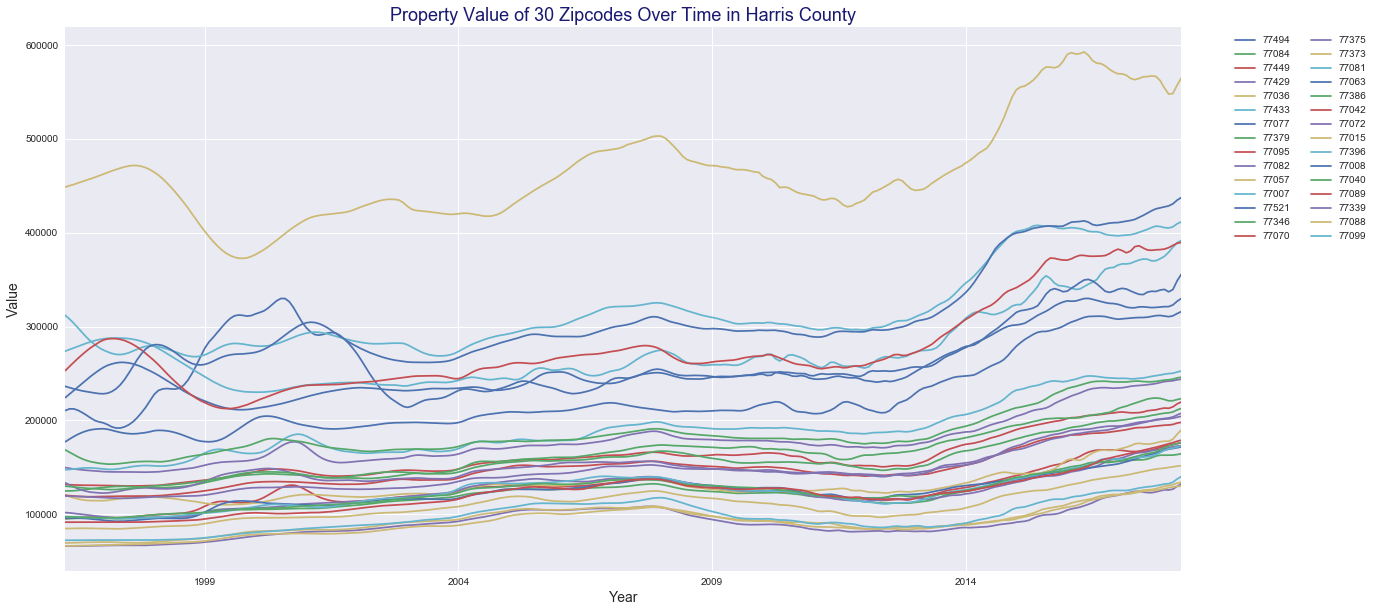

In [11]:
# Take the first 30 zipcodes to represent the trend of the property value over time
for zipcode in df_harris['RegionName'].iloc[:30]:
    df_harris2 = df_harris[df_harris.RegionName == zipcode].set_index('Month')
    df_harris2['MeanValue'].plot(figsize=(20,10), label=zipcode)
plt.legend(bbox_to_anchor=(1.04,1), loc='upper left', ncol=2)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Property Value of 30 Zipcodes Over Time in Harris County', color='midnightblue', fontsize=18);

##### Comment: 
There was a housing market crash in the years of 2008 and 2009, due to recession. There is a very strong correlation between the property recent value and the distant past value as the houses lose and recover their values over time. To make a good analysis for house market, we will limit the time from after 2012 which was the time after the recession.

In [12]:
df_harris_recent = df_harris[df_harris['Month'] >= '2012']
df_harris_recent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9196 entries, 22869 to 32064
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   RegionName  9196 non-null   int64         
 1   Month       9196 non-null   datetime64[ns]
 2   MeanValue   9196 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 287.4 KB


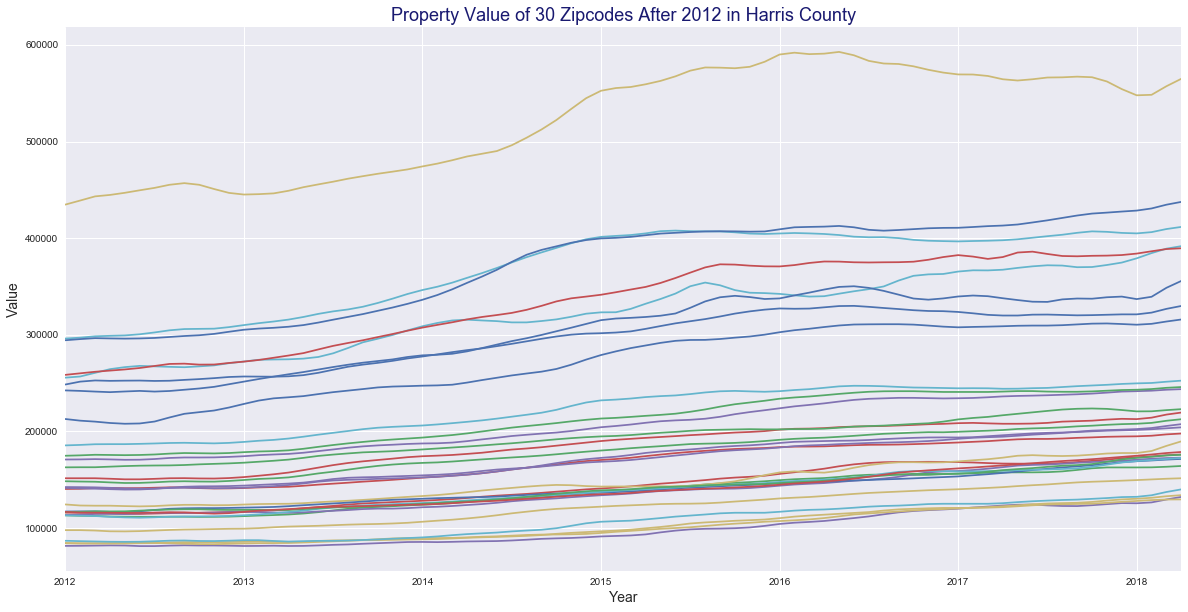

In [13]:
# Plot an example zipcode, to test outcome
for zipcode in df_harris_recent['RegionName'].iloc[:30]:
    df_harris_recent2 = df_harris_recent[df_harris_recent.RegionName == zipcode].set_index('Month')
    df_harris_recent2['MeanValue'].plot(figsize=(20,10), label=zipcode)

plt.xlabel('Year', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Property Value of 30 Zipcodes After 2012 in Harris County', color='midnightblue', fontsize=18);

# Time Series Analysis and SARIMAX Modeling

Return On Investment, or called ROI is used to determined the Top 5 Zipcodes in Harris Country, TX for investment. 

ROI is the ratio between new profit over a period of time and the cost of investment. Therefore, the higher ROI, the more profit returns from the investment.

In [14]:
# Make a dictionary for each zipcode
harris = {}
for zipcode in df_harris_recent.RegionName.unique():
    harris_temp = df_harris_recent[df_harris_recent.RegionName == zipcode].set_index('Month')
    harris_temp.drop('RegionName', axis=1, inplace=True)
    harris[zipcode] = harris_temp

In [15]:
# Log transform the values
harris_log = {}
for zipcode in harris.keys():
    harris_log[zipcode] = np.log(harris[zipcode])

In [16]:
# Perform difference on the log-transformed values
harris_diff = {}
for key in list(harris.keys()):
    harris_diff[key] = harris_log[key].diff(periods=12).dropna()

Text(0.5, 1.0, 'Property Value Over Time for Zipcode 77057')

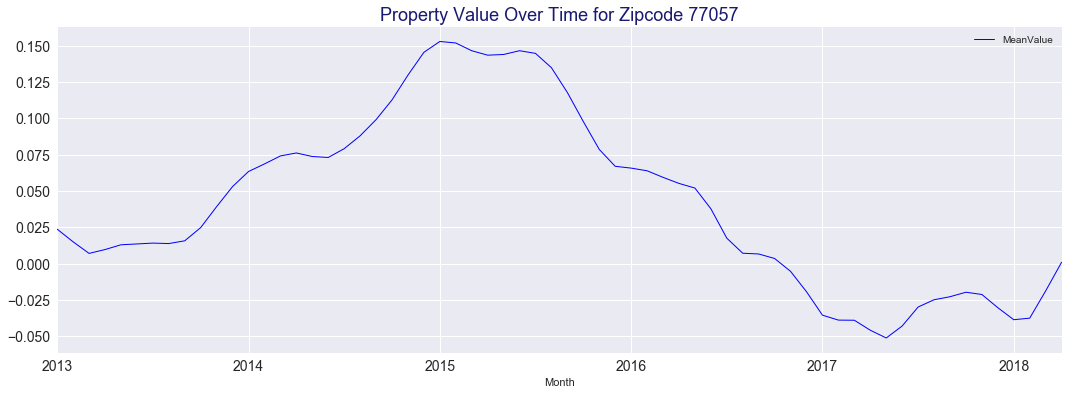

In [17]:
# Try with an example zipcode in Harris County
harris_diff[77057].plot(figsize=(18,6), color='blue', linewidth=1, fontsize=14)
plt.title('Property Value Over Time for Zipcode 77057', color='midnightblue', fontsize=18)

In [18]:
# Function to check for the stationarity of a time series
# with Rolling Statistics and Dickey-Fuller Test
def stationarity_check(TS, column_name):    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=7, center = False).mean()
    roll_std = TS.rolling(window=7, center = False).std()
    
    # Perform the Dickey-Fuller Test
    dftest = adfuller(TS[column_name]) 
    
    # Plot rolling statistics
    fig = plt.figure(figsize=(12,6))
    plt.plot(TS, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test: \n')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    return None

In [22]:
# Function to decompose a time series
# to remove trends and seasonality, and examine the residuals
def df_decompose(df):
    
    trend = sd(df).trend
    seasonal = sd(df).seasonal
    residual = sd(df).resid

    # Plot gathered statistics
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(df, label='Original', color="blue")
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color="blue")
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality', color="blue")
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color="blue")
    plt.legend(loc='best')
    plt.tight_layout();
    
    return residual.dropna()

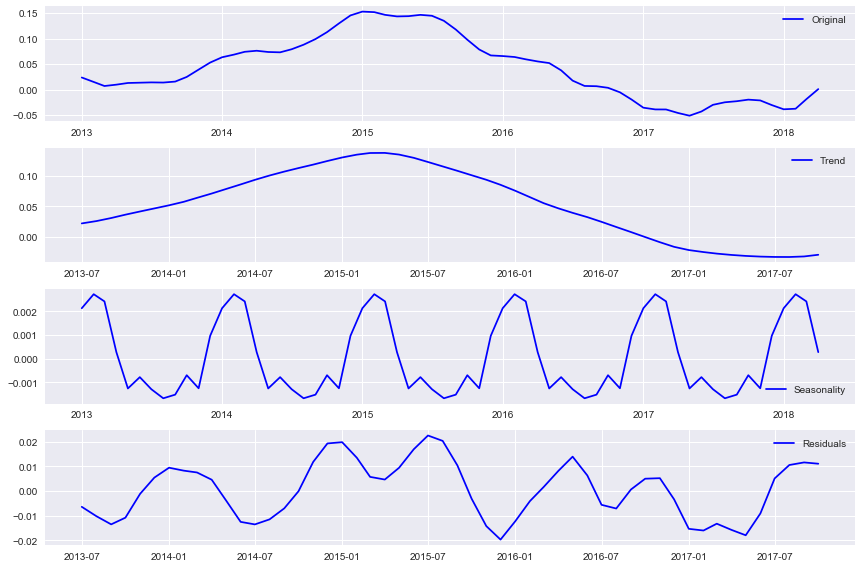

In [23]:
# Plot the time series decomposition for an example zipcode
decompose_77057 = df_decompose(harris_diff[77057])

##### Comment:
There is a upward trend in the data, along with very little seasonality (according to the y-axis).

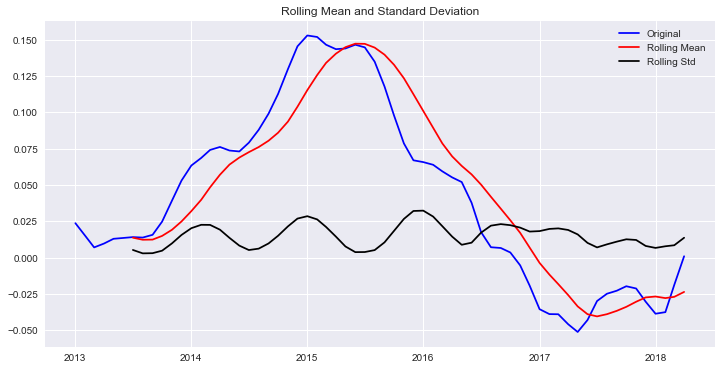

Results of Dickey-Fuller Test: 

Test Statistic                 -2.616156
p-value                         0.089704
#Lags Used                      8.000000
Number of Observations Used    55.000000
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
Critical Value (10%)           -2.595670
dtype: float64


In [24]:
stationarity_check(harris_diff[77057], 'MeanValue')

##### Comment:
The Dickey-Fuller test statistic is significant and very well below a (strict) 0.01 mark. Therefore, it is reasonable to assume this time series is stationary.

## SARIMAX Modeling

Because there is a little seasonality in out data, it is safer to use SARIMA (Seasonal Autoregressive Integrated Moving Average), instead of ARIMA (Autoregressive Integrated Moving Average) model. 

SARIMA is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component. The implementation is called SARIMAX instead of SARIMA because the 'X' addition to the method name means that the implementation also supports exogenous variables.

In [25]:
# Define the p, d and q parameters
p = d = q = range(0,4)
# Generate all different combinations of p, q and q
pdq = list(itertools.product(p,d,q))

In [30]:
def optimal_pdq(df, pdq):

    import warnings
    warnings.filterwarnings('ignore')
    
    results = []
    for params in pdq:
        try:
            model = SARIMAX(endog=df, order=params,
                            enforce_stationarity=False, enforce_invertibility=False)
            AIC = model.fit().aic
            results.append([params, AIC])
        except:
            continue

    results.sort(key=lambda x: x[-1])
    result_pdq = results[0][0]
    return (result_pdq)

In [31]:
# Find the optimal p, d, q values for an example zipcode
params_77057 = optimal_pdq(harris_log[77057], pdq)
params_77057

(2, 0, 3)

                               SARIMAX Results                                
Dep. Variable:              MeanValue   No. Observations:                   76
Model:               SARIMAX(2, 0, 3)   Log Likelihood                 320.899
Date:                Thu, 06 Aug 2020   AIC                           -629.797
Time:                        13:55:37   BIC                           -616.137
Sample:                    01-01-2012   HQIC                          -624.359
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8711      0.143     13.126      0.000       1.592       2.151
ar.L2         -0.8711      0.143     -6.109      0.000      -1.151      -0.592
ma.L1          0.9017      0.195      4.627      0.0

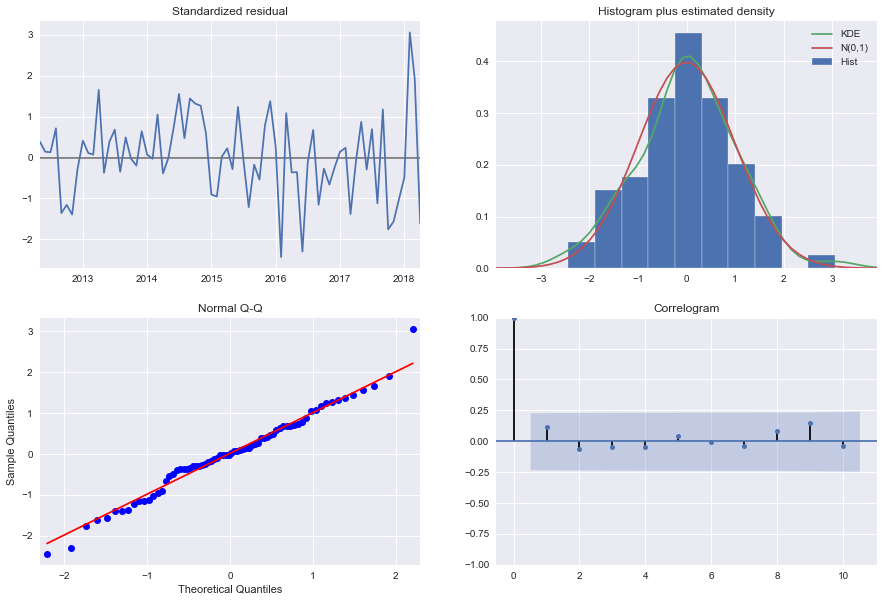

In [33]:
# plug the optimal parameter values into a new SARIMAX model.
model_77057 = SARIMAX(endog=harris_log[77057], order = params_77057,
                      enforce_stationarity=False, enforce_invertibility=False)
# Fit the model
fit_model_77057 = model_77057.fit()
# Print the summary table and plot diagnostics
print(fit_model_77057.summary())
fit_model_77057.plot_diagnostics(figsize=(15,10));

In [34]:
from statsmodels.tsa.arima_model import ARIMA

In [38]:
def melt_data(df):
    '''
    function to reshape dataframe into a pandas datetime from wide to long format
    '''
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

def evaluate_arima_model(X, arima_order):
    '''
    evaluate an ARIMA model for a given order (p,d,q)
    '''
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

def evaluate_models(dataset, p_values, d_values, q_values):
    '''
     evaluate combinations of p, d and q values for an ARIMA model
    '''
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg

In [39]:
roi_list = {}
for index, x in df[(df['CountyName'] == 'Harris') & (df['State'] == 'TX')].iterrows():
    '''
    function that loop through each single zipcode, apply and evaluate the best ARIMA model
    through the smallest MSE based on several values and 
    '''
    print(x['RegionName'])
    series = melt_data(df.loc[[index]])
    # evaluate parameters
    p_values = [0, 1, 2]
    d_values = range(0, 2)
    q_values = range(0, 2)
    warnings.filterwarnings("ignore")
    
    order = evaluate_models(series.values, p_values, d_values, q_values)
    
    model= ARIMA(series, order=order)
    model_fit= model.fit()
    thirty_six_months = model_fit.forecast(steps=36)[0][-1]
    today = series.iloc[-1].value
    roi = (thirty_six_months - today)/today
    roi_list[x['RegionName']] = roi

77494


ValueError: could not convert string to float: 'Katy'

In [ ]:
# Evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# Evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# Evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(df_harris.values, p_values, d_values, q_values)

In [ ]:
model = ARIMA(df_harris_melt, order=(2,2,2))
model_fit = model.fit(disp=0)
forecast = model_fit.forecast(36)

In [ ]:
actual_foreacst = forecast[0]
forecast_conf_int = forecast[2]

In [ ]:
df_harris_melt.tail(2)

In [ ]:
# make dataframe with forecast and 95% confidence interval 
df_forecast = pd.DataFrame({'time': pd.date_range(start = '2017-05-01', end = '2020-04-01', freq = 'MS')})
df_forecast['forecast'] = actual_foreacst
df_forecast['lower_bound'] = forecast_conf_int[:, 0]
df_forecast['upper_bound'] = forecast_conf_int[:, 1]
df_forecast.set_index('time', inplace = True)

In [ ]:
# combine raw data dataframe and forecast dataframe
df_new = pd.concat([df_harris_melt, df_forecast])

In [ ]:
df_new.head()

In [ ]:
fig = plt.figure(figsize = (12, 8))
plt.plot(df_new['value'], label = 'Raw Data')
plt.plot(df_new['forecast'], label = 'Forecast')
plt.fill_between(df_new.index, df_new['lower_bound'], df_new['upper_bound'], color="k", alpha=.15,
                label = 'Confidence Interval')
plt.legend(loc = 'upper left')
plt.title('Forecast for Harris County', color='midnightblue', fontsize=18)

In [ ]:
# forecasted price after 3 years
forcast_3_yrs = df_new.loc['2020-04-01', 'forecast']
forcast_lower = df_new.loc['2020-04-01', 'lower_bound']
forcast_upper = df_new.loc['2020-04-01', 'upper_bound']

In [ ]:
last_price = df_harris_melt.loc['2017-05-01', 'value']

In [ ]:
predicted_percent_change = (forcast_3_yrs - last_price) / last_price
predicted_percent_change